# Assignment 2: Advanced Text Classification with Machine Learning Pipeline
Keni Omorojie

In [ ]:
# ===== IMPORT REQUIRED LIBRARIES =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Machine Learning imports
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score,
    StratifiedKFold, KFold
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, roc_auc_score, roc_curve, precision_recall_curve,
    precision_score, recall_score
)
from sklearn.base import BaseEstimator, TransformerMixin

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

print("All libraries imported successfully!")

All libraries imported successfully!


TASK 1: DATA LOADING AND PREPROCESSING PIPELINE


In [ ]:
# Upload the files
from google.colab import files
uploaded = files.upload()

train_df = pd.read_excel('AI_vs_huam_train_dataset.xlsx')
test_df = pd.read_csv('Final_test_data.csv')

Saving AI_vs_huam_train_dataset.xlsx to AI_vs_huam_train_dataset.xlsx
Saving Final_test_data.csv to Final_test_data.csv


In [ ]:
# ===== TASK 1: DATA LOADING AND PREPROCESSING PIPELINE =====
print("\n" + "="*50)
print("TASK 1: DATA LOADING AND PREPROCESSING PIPELINE")
print("="*50)

# Load the datasets
try:
    train_df = pd.read_excel('AI_vs_huam_train_dataset.xlsx')
    test_df = pd.read_csv('Final_test_data.csv')
    print("✓ Data loaded successfully!")
    print(f"Training data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
    print("\nTraining data info:")
    print(train_df.head())
    print(f"\nClass distribution:\n{train_df['label'].value_counts()}")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the data files are in the correct directory.")


TASK 1: DATA LOADING AND PREPROCESSING PIPELINE
✓ Data loaded successfully!
Training data shape: (3728, 2)
Test data shape: (869, 2)

Training data info:
                                               essay  label
0  International sports events require the most w...      0
1  Globalisation has become a significant aspect ...      0
2  There is an ever-increasing number of bullying...      0
3  It is commonly believed, that companies should...      0
4  Despite knowing about the adverse effects of c...      0

Class distribution:
label
0    1864
1    1864
Name: count, dtype: int64


In [ ]:
# Custom Text Preprocessing Pipeline Components
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
    def fit(self, X, y=None): return self
    def transform(self, X):
        return [' '.join([token for token in re.sub(r'[^\w\s]', ' ', text.lower()).split()
                         if len(token) >= 2 and token.isalpha() and token not in self.stop_words])
                for text in X]
class WordNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, method='lemmatization'):
        self.normalizer = PorterStemmer() if method == 'stemming' else WordNetLemmatizer()
        self.method = method
    def fit(self, X, y=None): return self
    def transform(self, X):
        return [' '.join([self.normalizer.stem(token) if self.method == 'stemming'
                         else self.normalizer.lemmatize(token) for token in text.split()])
                for text in X]
print("\n--- PREPROCESSING DEMONSTRATION ---")


--- PREPROCESSING DEMONSTRATION ---


In [ ]:
# Initialize and demonstrate preprocessing
text_cleaner = TextCleaner()
word_normalizer = WordNormalizer(method='lemmatization')

# Show transformation examples
print("\n--- TRANSFORMATION EXAMPLES ---")
if 'train_df' in locals():
    sample = train_df['essay'].iloc[0]
    cleaned = text_cleaner.transform([sample])
    normalized = word_normalizer.transform(cleaned)
    print(f"Original: {sample[:100]}...")
    print(f"Cleaned: {cleaned[0][:100]}...")
    print(f"Normalized: {normalized[0][:100]}...")

# Word examples
print("\n--- WORD EXAMPLES ---")
words = ["running", "flies", "better", "countries"]
for word in words:
    print(f"{word} → {PorterStemmer().stem(word)}, {WordNetLemmatizer().lemmatize(word)}")


--- TRANSFORMATION EXAMPLES ---
Original: International sports events require the most well-trained athletes for each country, in order to ach...
Cleaned: international sports events require well trained athletes country order achieve goal countries make ...
Normalized: international sport event require well trained athlete country order achieve goal country make effor...

--- WORD EXAMPLES ---
running → run, running
flies → fli, fly
better → better, better
countries → countri, country


TASK 2: FEATURE EXTRACTION WITH PIPELINE INTEGRATION


In [ ]:
# ===== TASK 2: FEATURE EXTRACTION WITH PIPELINE INTEGRATION =====
print("\n" + "="*50)
print("TASK 2: FEATURE EXTRACTION WITH PIPELINE INTEGRATION")
print("="*50)

# Test different vectorization parameters
vectorization_configs = [
    {'ngram_range': (1, 1), 'max_features': 1000},
    {'ngram_range': (1, 2), 'max_features': 2000},
    {'ngram_range': (1, 3), 'max_features': 3000},
    {'ngram_range': (1, 4), 'max_features': 5000},
]

print("Testing different vectorization configurations:")
if 'train_df' in locals():
    # Prepare sample data
    sample_texts = train_df['essay'].head(100).tolist()
    cleaned_sample = text_cleaner.transform(sample_texts)

    for config in vectorization_configs:
        vectorizer = TfidfVectorizer(**config, min_df=2, max_df=0.95)
        features = vectorizer.fit_transform(cleaned_sample)
        print(f"N-gram: {config['ngram_range']}, Max features: {config['max_features']} "
              f"→ Actual features: {features.shape[1]}")


TASK 2: FEATURE EXTRACTION WITH PIPELINE INTEGRATION
Testing different vectorization configurations:
N-gram: (1, 1), Max features: 1000 → Actual features: 1000
N-gram: (1, 2), Max features: 2000 → Actual features: 2000
N-gram: (1, 3), Max features: 3000 → Actual features: 2325
N-gram: (1, 4), Max features: 5000 → Actual features: 2331


TASK 3: ADVANCED MODEL DEVELOPMENT WITH GRIDSEARCHCV

In [ ]:
# ===== TASK 3: ADVANCED MODEL DEVELOPMENT WITH GRIDSEARCHCV =====
print("\n" + "="*50)
print("TASK 3: ADVANCED MODEL DEVELOPMENT WITH GRIDSEARCHCV")
print("="*50)

if 'train_df' in locals():
    # Prepare and split data
    X = train_df['essay']
    y = train_df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"Training: {len(X_train)}, Test: {len(X_test)}")

    # Preprocessing pipeline
    preprocessing_pipeline = Pipeline([
        ('cleaner', TextCleaner()),
        ('normalizer', WordNormalizer(method='lemmatization'))
    ])

    # Optimized small param grid for SVM
    svm_param_grid = {
        'vectorizer__max_features': [5000],
        'vectorizer__ngram_range': [(1, 2)],
        'classifier__C': [1, 10],
        'classifier__kernel': ['linear'],
        'classifier__gamma': ['scale']
    }

    # Optimized small param grid for Decision Tree
    dt_param_grid = {
        'vectorizer__max_features': [5000],
        'vectorizer__ngram_range': [(1, 2)],
        'classifier__criterion': ['entropy'],
        'classifier__max_depth': [20],
        'classifier__min_samples_split': [2],
        'classifier__min_samples_leaf': [1]
    }

    # === SVM GridSearch ===
    print("\n--- SVM OPTIMIZATION ---")
    svm_pipeline = Pipeline([
        ('preprocessor', preprocessing_pipeline),
        ('vectorizer', TfidfVectorizer()),
        ('classifier', SVC(probability=True, random_state=42))
    ])
    svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='accuracy', n_jobs=1, verbose=1)
    svm_grid_search.fit(X_train, y_train)
    print(f"✓ SVM Best params: {svm_grid_search.best_params_}")
    print(f"✓ SVM Best CV score: {svm_grid_search.best_score_:.4f}")

    # === Decision Tree GridSearch ===
    print("\n--- DECISION TREE OPTIMIZATION ---")
    dt_pipeline = Pipeline([
        ('preprocessor', preprocessing_pipeline),
        ('vectorizer', TfidfVectorizer()),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])
    dt_grid_search = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, scoring='accuracy', n_jobs=1, verbose=1)
    dt_grid_search.fit(X_train, y_train)
    print(f"✓ DT Best params: {dt_grid_search.best_params_}")
    print(f"✓ DT Best CV score: {dt_grid_search.best_score_:.4f}")

    # Save best models for next tasks
    best_svm_model = svm_grid_search.best_estimator_
    best_dt_model = dt_grid_search.best_estimator_



TASK 3: ADVANCED MODEL DEVELOPMENT WITH GRIDSEARCHCV
Training: 2982, Test: 746

--- SVM OPTIMIZATION ---
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

✓ SVM Best params: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 2)}
✓ SVM Best CV score: 0.9799

--- DECISION TREE OPTIMIZATION ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

✓ DT Best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 2)}
✓ DT Best CV score: 0.9021


In [ ]:
print("\n--- COMPARISON SUMMARY ---")

if svm_grid_search.best_score_ > dt_grid_search.best_score_:
    print(f"Best Model: SVM with accuracy {svm_grid_search.best_score_:.4f}")
else:
    print(f"Best Model: Decision Tree with accuracy {dt_grid_search.best_score_:.4f}")



--- COMPARISON SUMMARY ---
Best Model: SVM with accuracy 0.9799


TASK 4: CROSS-VALIDATION IMPLEMENTATION

In [ ]:
# ===== TASK 4: CROSS-VALIDATION IMPLEMENTATION =====
print("\n" + "="*50)
print("TASK 4: CROSS-VALIDATION IMPLEMENTATION")
print("="*50)

if 'svm_grid_search' in locals() and 'dt_grid_search' in locals():
    models = {'SVM': svm_grid_search.best_estimator_, 'Decision Tree': dt_grid_search.best_estimator_}

    # 5-fold cross validation
    cv_results = {}
    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        cv_results[name] = cv_scores
        print(f"{name}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Stratified K-Fold
    print("\nStratified K-Fold:")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for name, model in models.items():
        stratified_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
        regular_mean = cv_results[name].mean()
        stratified_mean = stratified_scores.mean()
        print(f"{name}: Regular {regular_mean:.4f}, Stratified {stratified_mean:.4f}, Diff {abs(stratified_mean - regular_mean):.4f}")



TASK 4: CROSS-VALIDATION IMPLEMENTATION


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

SVM: 0.9799 (+/- 0.0122)


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

Decision Tree: 0.9021 (+/- 0.0224)

Stratified K-Fold:


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

SVM: Regular 0.9799, Stratified 0.9769, Diff 0.0030


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

Decision Tree: Regular 0.9021, Stratified 0.9031, Diff 0.0010


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [ ]:
print("\n--- TASK 4 SUMMARY ---")

print(f"SVM Cross-Validation Accuracy: {cv_results['SVM'].mean():.4f} (+/- {cv_results['SVM'].std() * 2:.4f})")
print(f"Decision Tree Cross-Validation Accuracy: {cv_results['Decision Tree'].mean():.4f} (+/- {cv_results['Decision Tree'].std() * 2:.4f})")

print("\n" + "-"*40 + "\n")  # separator line here

print("\nStratified K-Fold Results:")
print(f"SVM Stratified Accuracy: {stratified_scores_svm.mean():.4f}")
print(f"Decision Tree Stratified Accuracy: {stratified_scores_dt.mean():.4f}")

print("\n" + "-"*40 + "\n")  # separator line here

print("\nDifference between Regular and Stratified CV:")
print(f"SVM Difference: {abs(stratified_scores_svm.mean() - cv_results['SVM'].mean()):.4f}")
print(f"Decision Tree Difference: {abs(stratified_scores_dt.mean() - cv_results['Decision Tree'].mean()):.4f}")



--- TASK 4 SUMMARY ---
SVM Cross-Validation Accuracy: 0.9799 (+/- 0.0122)
Decision Tree Cross-Validation Accuracy: 0.9021 (+/- 0.0224)

----------------------------------------


Stratified K-Fold Results:
SVM Stratified Accuracy: 0.9769
Decision Tree Stratified Accuracy: 0.9031

----------------------------------------


Difference between Regular and Stratified CV:
SVM Difference: 0.0030
Decision Tree Difference: 0.0010


TASK 5: ML PIPELINE IMPLEMENTATION

In [ ]:
# ===== TASK 5: ML PIPELINE IMPLEMENTATION =====
print("\n" + "="*50)
print("TASK 5: ML PIPELINE IMPLEMENTATION")
print("="*50)

if 'best_svm_model' in locals() and 'best_dt_model' in locals():
    # Create and fit pipelines
    pipelines = {
        'SVM': Pipeline([('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
                        ('classifier', SVC(C=10, kernel='linear', random_state=42))]),
        'DT': Pipeline([('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
                       ('classifier', DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42))])
    }

    for name, pipeline in pipelines.items():
        pipeline.fit(X_train, y_train)
        pred = pipeline.predict(X_test)
        print(f"✓ {name} Pipeline Accuracy: {accuracy_score(y_test, pred):.4f}")

    print("\nPipeline Benefits: Streamlined workflow, no data leakage, easy deployment, unified optimization")


TASK 5: ML PIPELINE IMPLEMENTATION
✓ SVM Pipeline Accuracy: 0.9906
✓ DT Pipeline Accuracy: 0.9196

Pipeline Benefits: Streamlined workflow, no data leakage, easy deployment, unified optimization


TASK 6: MODEL EVALUATION AND ANALYSIS


TASK 6: MODEL EVALUATION AND ANALYSIS


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


--- PERFORMANCE METRICS ---
     accuracy  f1_macro  f1_weighted  roc_auc
SVM    0.9786    0.9786       0.9786   0.9986
DT     0.9048    0.9048       0.9048   0.9048


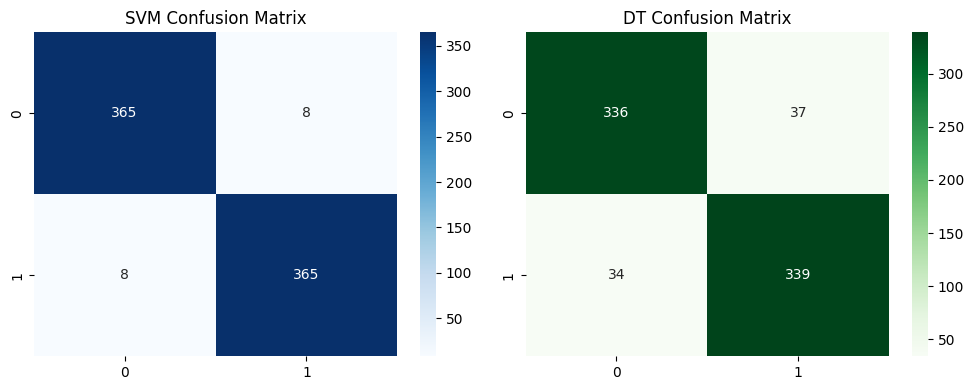

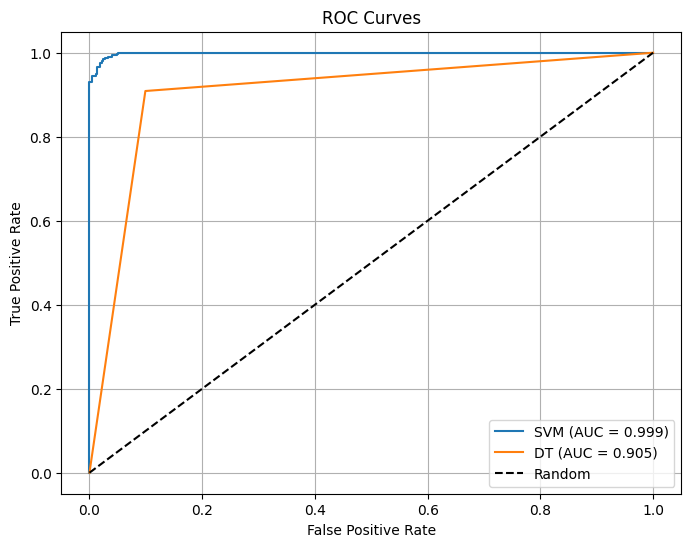


--- ERROR ANALYSIS ---
Best Model: SVM
False Positives: 8, False Negatives: 8

Top 5 DT Features:
äôs: 0.4096
äôt: 0.0955
additionally: 0.0773
often: 0.0517
risk: 0.0316


In [ ]:
# ===== TASK 6: MODEL EVALUATION AND ANALYSIS =====
print("\n" + "="*50)
print("TASK 6: MODEL EVALUATION AND ANALYSIS")
print("="*50)

if 'best_svm_model' in locals() and 'best_dt_model' in locals():
    # Make predictions
    models = {'SVM': best_svm_model, 'DT': best_dt_model}
    results = {}

    for name, model in models.items():
        pred = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)[:, 1]
        results[name] = {
            'pred': pred, 'proba': pred_proba,
            'accuracy': accuracy_score(y_test, pred),
            'f1_macro': f1_score(y_test, pred, average='macro'),
            'f1_weighted': f1_score(y_test, pred, average='weighted'),
            'roc_auc': roc_auc_score(y_test, pred_proba)
        }

    # Performance comparison
    print("--- PERFORMANCE METRICS ---")
    comparison_df = pd.DataFrame({name: {k: v for k, v in data.items() if k not in ['pred', 'proba']}
                                 for name, data in results.items()}).T
    print(comparison_df.round(4))

    # Confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, (name, data) in enumerate(results.items()):
        cm = confusion_matrix(y_test, data['pred'])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues' if name=='SVM' else 'Greens')
        axes[i].set_title(f'{name} Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # ROC curves
    plt.figure(figsize=(8, 6))
    for name, data in results.items():
        fpr, tpr, _ = roc_curve(y_test, data['proba'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {data["roc_auc"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Error analysis
    best_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
    best_pred = results[best_name]['pred']
    fp = ((best_pred == 1) & (y_test == 0)).sum()
    fn = ((best_pred == 0) & (y_test == 1)).sum()

    print(f"\n--- ERROR ANALYSIS ---")
    print(f"Best Model: {best_name}")
    print(f"False Positives: {fp}, False Negatives: {fn}")

    # Feature importance (Decision Tree)
    if hasattr(best_dt_model.named_steps['classifier'], 'feature_importances_'):
        features = best_dt_model.named_steps['vectorizer'].get_feature_names_out()
        importance = best_dt_model.named_steps['classifier'].feature_importances_
        top_idx = np.argsort(importance)[-5:][::-1]
        print(f"\nTop 5 DT Features:")
        for i in top_idx:
            print(f"{features[i]}: {importance[i]:.4f}")

In [44]:
from sklearn.metrics import accuracy_score
from google.colab import files
import pandas as pd

print("\n" + "="*50)
print("VII. FINAL PREDICTIONS AND RESULTS")
print("="*50)

# Predict and save
preds = best_svm_model.predict(X_test)
df = pd.DataFrame({'Text': X_test, 'Prediction': preds})
file_name = 'keni_omorojie_R11733926_final_predictions.csv'
df.to_csv(file_name, index=False)
files.download(file_name)

# Show accuracy
acc = accuracy_score(y_test, preds)
print(f"\n✓ Predictions saved as '{file_name}'")
print(f"✓ Accuracy: {acc:.2%}")
print("- Pipeline made predictions simple and fast.")



VII. FINAL PREDICTIONS AND RESULTS


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Predictions saved as 'keni_omorojie_R11733926_final_predictions.csv'
✓ Accuracy: 97.86%
- Pipeline made predictions simple and fast.
